# Load the model

In [1]:
import os
import torch
from torch.utils.data import TensorDataset, DataLoader
import glob
import time
import timm
import numpy as np
import pandas as pd
import mmcv, cv2
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from PIL import Image, ImageDraw, ImageFont, ImageEnhance
from IPython import display
from tqdm import tqdm
import seaborn
from matplotlib import pyplot as plt

Image.__version__

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu = torch.device('cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [2]:
import torch.nn as nn

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x


class DFDCNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers, drop_prob=0.5):
        super(DFDCNet, self).__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.mixnet = timm.create_model("mixnet_s", pretrained=True)
        self.mixnet.classifier = Identity()
#         l = 0
#         for param in self.mixnet.parameters():
#             l = l + 1
#             if l > 200:
#                 param.requires_grad = True
                
        self.lstm = nn.LSTM(1536, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_dim)
        self.elu = nn.ELU()
        self.fc1 = nn.Linear(hidden_dim, 32)
#         self.fc2 = nn.Linear(64, 32)
#         self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(32, output_size)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, hidden):
        batch_size, seqlen, c, h, w = x.size()
        x = x.reshape(batch_size*seqlen, c, h, w).float()
        x = self.mixnet(x)
        x = x.reshape(batch_size, seqlen, x.shape[1])
        lstm_out, hidden = self.lstm(x, hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
#         out = self.batchnorm(out)
        out = self.fc1(out)
        out = self.elu(out)
#         out = self.fc2(out)
#         out = self.elu(out)
#         out = self.fc3(out)
#         out = self.elu(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        
        out = out.view(batch_size, -1)
        out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden

In [3]:
input_size = 512
output_size = 1
hidden_dim = 512
n_layers = 2

model = DFDCNet(input_size, output_size, hidden_dim, n_layers)
model.to(device)
model.load_state_dict(torch.load('model_1face_unfroze.pt'))

<All keys matched successfully>

In [4]:
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, log_loss
import seaborn as sns

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

def plot_matrix(target, predicted_binary, name):
    matrix = confusion_matrix(target, predicted_binary)
    TN, FP, FN, TP = matrix.ravel()
    if (TP + FP > 0) and (TP + FN > 0):
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F =  2 * (precision*recall) / (precision + recall)
    else:
        F = 0
    cm_df = pd.DataFrame(matrix,
                         index = ['Nagative', 'Positive'], 
                         columns = ['Nagative', 'Positive'])
    subtitle = 'Precision ' + str(round(precision, 2)) + ' Recall ' + str(round(recall, 2))
    fig, ax = plt.subplots(figsize=(8,6))
    ax = sns.heatmap(cm_df, annot=True, fmt="d")
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.title('Confusion Matrix - ' + name + "\n" + subtitle)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [5]:
for p in tqdm(np.arange(0, 50), total = 50):
    if p == 0:
        metadata = torch.load('data_images/000metadata_part_' + str(p) + '.pt', map_location = cpu)
    else:
        metadata_p = torch.load('data_images/000metadata_part_' + str(p) + '.pt', map_location = cpu)
        metadata = pd.concat([metadata, metadata_p])

100%|██████████| 50/50 [04:03<00:00,  1.29it/s]


In [6]:
metadata.n_face.value_counts()

1    104891
2      8879
0      5076
3       308
Name: n_face, dtype: int64

# 1 Face

In [17]:
X = np.array(metadata.index[metadata.n_face == 1])
Y = np.array(1 * (metadata.label[metadata.n_face == 1] == 'REAL'))

In [18]:
print(len(X))

print(len(Y))

104891
104891


In [19]:
from torch.utils import data
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = torch.load('data_images/1face_X_'+ ID + '.pt', map_location = cpu)
        y = self.labels[index]

        return X[[0,2,4,6,8]], y

In [27]:
! rm log_evaluation.log

In [28]:
import logging
from datetime import datetime
batch = 25
logging.basicConfig(filename = 'log_evaluation.log',level = logging.INFO)
counter = 0
params = {'batch_size': batch, 'shuffle': False, 'num_workers': batch}
predict = []
test_set = Dataset(X, Y)
test_generator = data.DataLoader(test_set, **params)
torch.cuda.empty_cache() 


In [29]:
for inputs, label in tqdm(test_generator):
    test_h = model.init_hidden(len(label))
    test_h = tuple([each.data for each in test_h])
    inputs = inputs.to(device)
    out, test_h = model(inputs, test_h)
    y = out.squeeze().cpu().data.numpy()
    predict.append(y)
    torch.cuda.empty_cache() 
    counter += 1
    
    if counter % 100 == 0:
        logging.info(str(counter) + datetime.now().strftime("%H:%M:%S")) 

100%|██████████| 4196/4196 [2:18:47<00:00,  5.72it/s]  


In [30]:
len(predict)

4196

In [31]:
pred = np.concatenate(predict)

In [34]:
len(pred)

104891

In [35]:
threshold = Find_Optimal_Cutoff(Y, pred)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in pred]

the optimal threshold is 0.010755735449492931


In [36]:
log_loss(Y, pred)

0.253004628008593

In [37]:
matrix = confusion_matrix(Y, predict_b)

In [45]:
matrix

array([[77748,  9796],
       [ 1941, 15406]])

In [46]:
matrix.ravel()

array([77748,  9796,  1941, 15406])

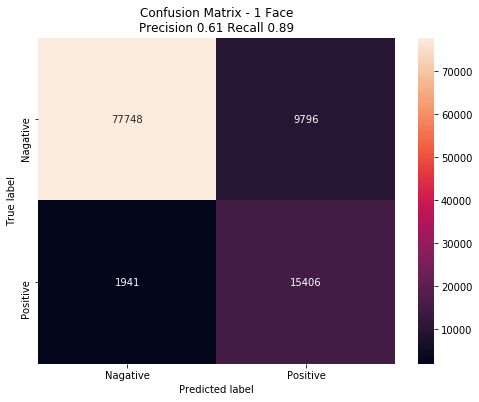

In [50]:
plot_matrix(Y, predict_b, name = '1 Face')

# 2 Face

In [7]:
X = np.array(metadata.index[metadata.n_face == 2])
Y = np.array(1 * (metadata.label[metadata.n_face == 2] == 'REAL'))

In [8]:
print(len(X))

print(len(Y))

8879
8879


In [9]:
! rm log_evaluation.log

rm: cannot remove 'log_evaluation.log': No such file or directory


In [10]:
from torch.utils import data
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = torch.load('data_images/2face_X_'+ ID + '.pt', map_location = cpu)
        y = self.labels[index]

        return X[[0,1, 4,5, 8,9, 12,13, 16,17]], y

In [11]:
import logging
from datetime import datetime
batch = 10
logging.basicConfig(filename = 'log_evaluation.log',level = logging.INFO)
counter = 0
params = {'batch_size': batch, 'shuffle': False, 'num_workers': batch}
predict = []
test_set = Dataset(X, Y)
test_generator = data.DataLoader(test_set, **params)
torch.cuda.empty_cache() 


In [17]:
for inputs, label in tqdm(test_generator):
    test_h = model.init_hidden(len(label))
    test_h = tuple([each.data for each in test_h])
    inputs = inputs.to(device)
    input1 = inputs[:,[0,2,4,6,8], :, :, :]
    out, test_h = model(input1, test_h)
    y1 = out.squeeze().cpu().data.numpy()
    
    input2 = inputs[:,[1,3,5,7,9], :, :, :]
    out, test_h = model(input1, test_h)
    y2 = out.squeeze().cpu().data.numpy()
    
    predict.append(np.maximum(y1, y2))
    torch.cuda.empty_cache() 
    counter += 1
    
    if counter % 100 == 0:
        logging.info(str(counter) + datetime.now().strftime("%H:%M:%S")) 

100%|██████████| 888/888 [15:50<00:00,  4.45it/s]  


In [18]:
len(predict)

888

In [19]:
pred = np.concatenate(predict)

In [20]:
len(pred)

8879

In [21]:
threshold = Find_Optimal_Cutoff(Y, pred)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in pred]

the optimal threshold is 0.003690990386530757


In [22]:
log_loss(Y, pred)

0.6376042047006321

In [23]:
matrix = confusion_matrix(Y, predict_b)

In [24]:
matrix

array([[5013, 2587],
       [ 436,  843]])

In [25]:
matrix.ravel()

array([5013, 2587,  436,  843])

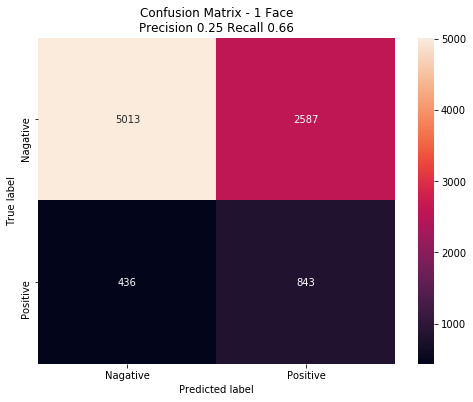

In [26]:
plot_matrix(Y, predict_b, name = '1 Face')

# 3 Face

In [27]:
X = np.array(metadata.index[metadata.n_face == 3])
Y = np.array(1 * (metadata.label[metadata.n_face == 3] == 'REAL'))

In [28]:
print(len(X))

print(len(Y))

308
308


In [29]:
! rm log_evaluation.log

In [33]:
from torch.utils import data
class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, list_IDs, labels):
        'Initialization'
        self.labels = labels
        self.list_IDs = list_IDs

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.list_IDs)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = torch.load('data_images/3face_X_'+ ID + '.pt', map_location = cpu)
        y = self.labels[index]

        return X[[0,1,2, 6,7,8, 12,13,14, 18,19,20, 24,25,26]], y

In [34]:
import logging
from datetime import datetime
batch = 10
logging.basicConfig(filename = 'log_evaluation.log',level = logging.INFO)
counter = 0
params = {'batch_size': batch, 'shuffle': False, 'num_workers': batch}
predict = []
test_set = Dataset(X, Y)
test_generator = data.DataLoader(test_set, **params)
torch.cuda.empty_cache() 


In [35]:
for inputs, label in tqdm(test_generator):
    test_h = model.init_hidden(len(label))
    test_h = tuple([each.data for each in test_h])
    inputs = inputs.to(device)
    input1 = inputs[:,[0,3,6,9,12], :, :, :]
    out, test_h = model(input1, test_h)
    y1 = out.squeeze().cpu().data.numpy()
    
    input2 = inputs[:,[1,4,7,10,13], :, :, :]
    out, test_h = model(input1, test_h)
    y2 = out.squeeze().cpu().data.numpy()
    
    input3 = inputs[:,[2,5,8,11,14], :, :, :]
    out, test_h = model(input1, test_h)
    y3 = out.squeeze().cpu().data.numpy()
    
    predict.append(np.maximum(y1, y2, y3))
    torch.cuda.empty_cache() 
    counter += 1
    
    if counter % 100 == 0:
        logging.info(str(counter) + datetime.now().strftime("%H:%M:%S")) 


100%|██████████| 31/31 [00:20<00:00,  1.10it/s]

In [36]:
len(predict)

31

In [37]:
pred = np.concatenate(predict)

In [38]:
len(pred)

308

In [39]:
threshold = Find_Optimal_Cutoff(Y, pred)
print("the optimal threshold is " + str(threshold[0]))
predict_b = [1 if p > threshold[0] else 0 for p in pred]

the optimal threshold is 0.019933953881263733


In [40]:
log_loss(Y, pred)

0.22493038172036572

In [41]:
matrix = confusion_matrix(Y, predict_b)

In [42]:
matrix

array([[237,  29],
       [  5,  37]])

In [43]:
matrix.ravel()

array([237,  29,   5,  37])

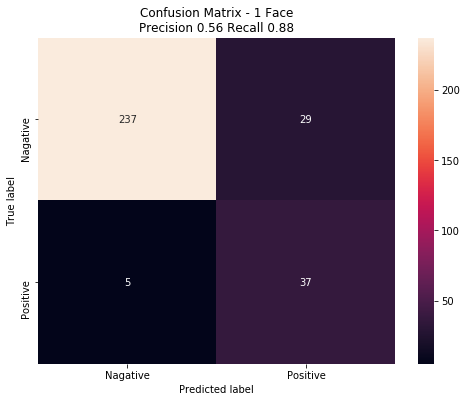

In [44]:
plot_matrix(Y, predict_b, name = '1 Face')